In [1]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils as nn_utils
from torch.utils.data import Dataset, DataLoader
import torch.cuda.amp as amp
from torch.cuda.amp import autocast, GradScaler

import itertools
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

# from box import Box

import warnings

import FastAttention2 as FastAttention
from FastAttention2 import kernel

In [2]:
config = {
    'data_path' : '/gpfs/u/home/TMSR/TMSRvldn/scratch/recsys/ratings.dat',
    'max_len' : 50, # maximum length of input sequences
    'hidden_units' : 64, # Embedding size
    'num_heads' : 2, # Multi-head layer
    'num_layers': 2, # block (encoder layer)
    'dropout_rate' : 0.1, # dropout rate for regularization
    'lr' : 0.001,
    'batch_size' : 128,
    'num_epochs' : 25,
    'num_workers' : 2,
    'mask_prob' : 0.15, # for cloze task
    'weight_decay' : 0.001,
    'grad_clip' : 1.0,
}

seed = 42  
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Dataset

In [3]:
import pandas as pd
from collections import defaultdict

class MakeSequenceDataSet():
    """
    SequenceData
    """
    def __init__(self, config):
        self.df = pd.read_csv(config['data_path'], sep="::", names=["UserID", "MovieID", "Rating", "Timestamp"], engine="python")
        # create encoders and decoders for both movieID and userID
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('MovieID')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('UserID')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        # converting user and item IDs into numerical indices
        self.df['item_idx'] = self.df['MovieID'].apply(lambda x : self.item_encoder[x] + 1) # takes each movieID, looks up its corr. index in the self.item_encoder dictionary, then increments the label by 1. (WHY?)
        self.df['user_idx'] = self.df['UserID'].apply(lambda x : self.user_encoder[x]) # converts each userID into a numerical index using the self.user_encoder dictionary. The result is stored in the user_idx column
        # sorting by user_idx and timestamp ensures that the data fed into the model respects the order of events which is critical for any sequence prediction task
        self.df = self.df.sort_values(['user_idx', 'Timestamp'])
        self.user_train, self.user_valid = self.generate_sequence_data() # diff

    # facilitates the transformation of categorical data into a numerical format that can be processed by neural networks
    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder

        Args:
            col (str):  columns
        Returns:
            dict: user encoder, decoder
        """
        # takes a column name and generates dictionaries to map unique values to indices (encoder) and indicies back to values (decoder)
        # encoders and decoders are useful for converting categorical variables into indices which are more manageable for models and for interpreting the outputs of the model.
        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder

    # creates sequences of interactions for each user. This is done by iterating through sorted data to maintain the temporal order of interactions
    # the result is a dictionary where each key is a user_id and the value is a list of items interacted with by the user
    def generate_sequence_data(self) -> dict:
        """
        sequence_data

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())

        for user in users:
            user_train[user] = users[user][:-1]
            user_valid[user] = [users[user][-1]]

        return user_train, user_valid

    def get_train_valid_data(self):
        return self.user_train, self.user_valid

In [4]:
s = MakeSequenceDataSet(config)

In [5]:
# handles data preprocessing for a BERT-based model
class BERTRecDataSet(Dataset):
    def __init__(self, user_train, max_len, num_user, num_item, mask_prob):
        self.user_train = user_train
        self.max_len = max_len
        self.num_user = num_user
        self.num_item = num_item
        self.mask_prob = mask_prob
        self._all_items = set([i for i in range(1, self.num_item + 1)])

    def __len__(self):
        #  user sequence
        return self.num_user

    def __getitem__(self, user):

        user_seq = self.user_train[user]
        tokens = []
        labels = []
        for s in user_seq[-self.max_len:]:
            prob = np.random.random()
            if prob < self.mask_prob:
                prob /= self.mask_prob
                if prob < 0.8:
                    # masking
                    tokens.append(self.num_item + 1)  # mask_index: num_item + 1, 0: pad, 1~num_item: item index
                elif prob < 0.9:
                    # noise
                    tokens.extend(self.random_neg_sampling(rated_item = user_seq, num_item_sample = 1))  # item random sampling
                else:
                    tokens.append(s)
                labels.append(s)
            else:
                tokens.append(s)
                labels.append(0)

        mask_len = self.max_len - len(tokens)
        tokens = [0] * mask_len + tokens
        labels = [0] * mask_len + labels

        return torch.LongTensor(tokens), torch.LongTensor(labels)

    def random_neg_sampling(self, rated_item : list, num_item_sample : int):
        nge_samples = random.sample(list(self._all_items - set(rated_item)), num_item_sample)
        return nge_samples


# Model Architecture

In [6]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model): # d_model is the size of the embeddings (the size of each token's embedding vector)
        super().__init__()

        # Compute the positional encodings once in log space.
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)

class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, embed_size=512):
        super().__init__(vocab_size, embed_size, padding_idx=0)

In [7]:
class BERTEmbedding(nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)

        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, max_len, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """
        super().__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(max_len=max_len, d_model=embed_size)
        # self.segment = SegmentEmbedding(embed_size=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence):
        x = self.token(sequence) + self.position(sequence)
        return self.dropout(x)

In [8]:
b = BERTEmbedding(26744, 768, 150, dropout=0.1)

In [9]:
b.position.pe

Embedding(150, 768)

In [10]:
class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

In [11]:
class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

In [12]:
class GELU(nn.Module):
    """
    Paper Section 3.4, last paragraph notice that BERT used the GELU instead of RELU
    """

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [13]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))

In [14]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [15]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [16]:
class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

In [17]:
class BERT(nn.Module):
    def __init__(self, bert_max_len, num_items, bert_num_blocks, bert_num_heads,
                 bert_hidden_units, bert_dropout):
        super().__init__()

        # fix_random_seed_as(args.model_init_seed)
        # self.init_weights()

        max_len = bert_max_len
        num_items = num_items
        n_layers = bert_num_blocks
        heads = bert_num_heads
        vocab_size = num_items + 2
        hidden = bert_hidden_units
        self.hidden = hidden
        dropout = bert_dropout

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=self.hidden, max_len=max_len, dropout=dropout)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, heads, hidden * 4, dropout) for _ in range(n_layers)])
        self.out = nn.Linear(hidden, num_items + 1)

    def forward(self, x):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x)
        
        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        x = self.out(x)
        return x

    def init_weights(self):
        pass

net = BERT(10, 10, 6, 8, 8, 0.4)


In [18]:
def train(model, criterion, optimizer, data_loader, scheduler=None, config=None, device='cuda'):
    """
    Training loop without AMP.
    This version uses standard 32-bit precision and includes gradient clipping.
    """
    model.train()
    loss_val = 0.0

    for seq, labels in tqdm(data_loader):
        seq = seq.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        # Forward pass (no autocast here)
        logits = model(seq)
        logits = logits.view(-1, logits.size(-1))  # reshape to (batch_size * seq_len, vocab)
        labels = labels.view(-1)                   # reshape to (batch_size * seq_len)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients as specified in your config
        nn_utils.clip_grad_norm_(model.parameters(), config['grad_clip'])
        
        # Optimizer step and scheduler update
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
            
        loss_val += loss.item()

    loss_val /= len(data_loader)
    return loss_val

def evaluate(model, user_train, user_valid, max_len, data_loader, bert4rec_dataset, make_sequence_dataset):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    num_item_sample = 100

    users = [user for user in range(make_sequence_dataset.num_user)]

    for user in tqdm(users):
        seq = (user_train[user] + [make_sequence_dataset.num_item + 1])[-max_len:] # mask last token
        padding_len = max_len - len(seq)
        seq = [0] * padding_len + seq
        rated = user_train[user] + user_valid[user]
        items = user_valid[user] + bert4rec_dataset.random_neg_sampling(rated_item = rated, num_item_sample = num_item_sample)

        with torch.no_grad():
            seq = torch.LongTensor([seq]).to(device)
            predictions = -model(seq)
            predictions = predictions[0][-1][items] # sampling
            rank = predictions.argsort().argsort()[0].item() # label


        if rank < 10: #Top10
            NDCG += 1 / np.log2(rank + 2)
            HIT += 1

    NDCG /= len(users)
    HIT /= len(users)

    return NDCG, HIT


In [19]:
make_sequence_dataset = MakeSequenceDataSet(config)

In [20]:
user_train, user_valid = make_sequence_dataset.get_train_valid_data()

In [21]:
bert4rec_dataset = BERTRecDataSet(
    user_train = user_train,
    max_len = config['max_len'],
    num_user = make_sequence_dataset.num_user,
    num_item = make_sequence_dataset.num_item,
    mask_prob = config['mask_prob'],
    )

In [22]:
data_loader = DataLoader(
    bert4rec_dataset,
    batch_size = config['batch_size'],
    shuffle = True,
    pin_memory = True,
    num_workers = config['num_workers'],
    )

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BERT(
    num_items = 26744,
    bert_hidden_units = config['hidden_units'],
    bert_num_heads = config['num_heads'],
    bert_num_blocks = config['num_layers'],
    bert_max_len = config['max_len'],
    bert_dropout = config['dropout_rate'],
    ).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0) # label (padding)
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

In [24]:
def get_scheduler(optimizer, warmup_steps, total_steps):
    """
    Simple linear warmup + linear decay:
    - LR ramps up linearly from 0 to base_lr over `warmup_steps`
    - Then decays linearly back to 0 over the remaining steps.
    """
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        else:
            return max(
                0.0,
                1.0 - float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
            )

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

total_steps = len(data_loader) * config['num_epochs']  # e.g. total updates
warmup_steps = 0.1 * total_steps
scheduler = get_scheduler(optimizer, warmup_steps, total_steps)

In [25]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [26]:
start_time = time.time()
loss_list = []
ndcg_list = []
hit_list = []
memory_list = []

# Remove early stopping variables
# best_ndcg = 0.0
# epochs_no_improve = 0
# patience = 5

num_epochs = config['num_epochs']

for epoch in tqdm(range(1, num_epochs + 1)):
    # Reset peak memory stats at the beginning of each epoch
    torch.cuda.reset_peak_memory_stats(device)

    # Log memory before training (optional)
    mem_before = torch.cuda.memory_allocated(device) / 1024**2
    print(f"Epoch {epoch} - GPU Memory Allocated before training: {mem_before:.2f} MB")

    # 1) Training step
    train_loss = train(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        data_loader=data_loader,
        scheduler=scheduler,
        config=config,
        device=device
    )
    loss_list.append(train_loss)
    print(f'Epoch: {epoch:3d} | Train loss: {train_loss:.5f}')

    # Log peak memory usage during training
    peak_mem = torch.cuda.max_memory_allocated(device) / 1024**2  # in MB
    memory_list.append(peak_mem)
    print(f"Epoch {epoch} - Peak GPU Memory during training: {peak_mem:.2f} MB")

    # 2) Validation step (NDCG, HIT)
    ndcg, hit = evaluate(
        model=model,
        user_train=user_train,
        user_valid=user_valid,
        max_len=config['max_len'],
        data_loader=None,
        make_sequence_dataset=make_sequence_dataset,
        bert4rec_dataset=bert4rec_dataset
    )
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    print(f'NDCG@10: {ndcg:.4f} | HIT@10: {hit:.4f}')

    # (Early stopping logic removed; run for all epochs)

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time for {num_epochs} epochs: {total_time:.2f} seconds")

# After training, compute the best metrics
best_ndcg = max(ndcg_list)
best_hit = max(hit_list)
peak_memory = max(memory_list)
print(f"Best NDCG@10 achieved: {best_ndcg:.4f}")
print(f"Best HIT@10 achieved: {best_hit:.4f}")
print(f"Peak GPU Memory: {peak_memory:.4f}")

# Save the final model and optionally the best model (if desired)
torch.save(model.state_dict(), "final_checkpoint.pth")

  0%|                                                                                                                                                                 | 0/25 [00:00<?, ?it/s]

Epoch 1 - GPU Memory Allocated before training: 13.56 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:20,  2.27it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:03, 13.57it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 22.31it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:01, 28.99it/s]
%|██████████████████████████████████████████████████████████████

Epoch:   1 | Train loss: 10.47555
Epoch 1 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|▉                                                                                                                                                    | 37/6040 [00:00<00:16, 367.56it/s]
%|██▏                                                                                                                                                  | 88/6040 [00:00<00:13, 447.04it/s]
%|███▍                                                                                                                                                | 139/6040 [00:00<00:12, 472.53it/s]
%|████▋                                                                                                                                               | 190/6040 [00:00<00:12, 483.28it/s]
%|█████▉                                                        

NDCG@10: 0.0652 | HIT@10: 0.1409
Epoch 2 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.78it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 28.60it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 36.54it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 40.61it/s]
%|██████████████████████████████████████████████████████████████

Epoch:   2 | Train loss: 8.92244
Epoch 2 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 53/6040 [00:00<00:11, 522.36it/s]
%|██▌                                                                                                                                                 | 106/6040 [00:00<00:11, 521.86it/s]
%|███▉                                                                                                                                                | 159/6040 [00:00<00:11, 520.90it/s]
%|█████▏                                                                                                                                              | 212/6040 [00:00<00:11, 520.42it/s]
%|██████▍                                                       

NDCG@10: 0.2227 | HIT@10: 0.4177
Epoch 3 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:05,  8.50it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 29.37it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 36.84it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 40.42it/s]
%|██████████████████████████████████████████████████████████████

Epoch:   3 | Train loss: 7.76951
Epoch 3 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 54/6040 [00:00<00:11, 531.61it/s]
%|██▋                                                                                                                                                 | 108/6040 [00:00<00:11, 530.92it/s]
%|███▉                                                                                                                                                | 162/6040 [00:00<00:11, 532.37it/s]
%|█████▎                                                                                                                                              | 216/6040 [00:00<00:10, 532.36it/s]
%|██████▌                                                       

NDCG@10: 0.2450 | HIT@10: 0.4581
Epoch 4 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:05,  8.48it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 29.25it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 36.36it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 40.21it/s]
%|██████████████████████████████████████████████████████████████

Epoch:   4 | Train loss: 7.63282
Epoch 4 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 54/6040 [00:00<00:11, 535.66it/s]
%|██▋                                                                                                                                                 | 108/6040 [00:00<00:11, 534.50it/s]
%|███▉                                                                                                                                                | 162/6040 [00:00<00:11, 532.25it/s]
%|█████▎                                                                                                                                              | 216/6040 [00:00<00:10, 532.48it/s]
%|██████▌                                                       

NDCG@10: 0.2459 | HIT@10: 0.4583
Epoch 5 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:05,  8.60it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 30.25it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:00, 37.79it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 41.51it/s]
%|██████████████████████████████████████████████████████████████

Epoch:   5 | Train loss: 7.56142
Epoch 5 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 53/6040 [00:00<00:11, 523.86it/s]
%|██▌                                                                                                                                                 | 106/6040 [00:00<00:11, 523.12it/s]
%|███▉                                                                                                                                                | 159/6040 [00:00<00:11, 522.16it/s]
%|█████▏                                                                                                                                              | 212/6040 [00:00<00:11, 522.57it/s]
%|██████▍                                                       

NDCG@10: 0.2536 | HIT@10: 0.4594
Epoch 6 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:05,  8.56it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 30.17it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:00, 37.92it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 41.67it/s]
%|██████████████████████████████████████████████████████████████

Epoch:   6 | Train loss: 7.51453
Epoch 6 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▏                                                                                                                                                   | 50/6040 [00:00<00:12, 492.35it/s]
%|██▍                                                                                                                                                 | 100/6040 [00:00<00:12, 490.67it/s]
%|███▋                                                                                                                                                | 150/6040 [00:00<00:12, 489.50it/s]
%|████▉                                                                                                                                               | 200/6040 [00:00<00:11, 491.65it/s]
%|██████▏                                                       

NDCG@10: 0.2554 | HIT@10: 0.4657
Epoch 7 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.48it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 27.81it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 35.63it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 39.56it/s]
%|██████████████████████████████████████████████████████████████

Epoch:   7 | Train loss: 7.49283
Epoch 7 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▏                                                                                                                                                   | 49/6040 [00:00<00:12, 488.39it/s]
%|██▍                                                                                                                                                  | 98/6040 [00:00<00:12, 488.36it/s]
%|███▋                                                                                                                                                | 148/6040 [00:00<00:12, 489.44it/s]
%|████▊                                                                                                                                               | 197/6040 [00:00<00:11, 487.96it/s]
%|██████                                                        

NDCG@10: 0.2587 | HIT@10: 0.4687
Epoch 8 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.54it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 27.38it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 35.08it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 39.09it/s]
%|██████████████████████████████████████████████████████████████

Epoch:   8 | Train loss: 7.46903
Epoch 8 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▏                                                                                                                                                   | 50/6040 [00:00<00:12, 495.60it/s]
%|██▍                                                                                                                                                 | 100/6040 [00:00<00:12, 490.83it/s]
%|███▋                                                                                                                                                | 150/6040 [00:00<00:12, 490.40it/s]
%|████▉                                                                                                                                               | 200/6040 [00:00<00:11, 490.72it/s]
%|██████▏                                                       

NDCG@10: 0.2606 | HIT@10: 0.4717
Epoch 9 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.19it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 27.41it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 35.30it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 39.31it/s]
%|██████████████████████████████████████████████████████████████

Epoch:   9 | Train loss: 7.43146
Epoch 9 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▏                                                                                                                                                   | 50/6040 [00:00<00:12, 495.74it/s]
%|██▍                                                                                                                                                 | 100/6040 [00:00<00:12, 491.92it/s]
%|███▋                                                                                                                                                | 150/6040 [00:00<00:11, 492.18it/s]
%|████▉                                                                                                                                               | 200/6040 [00:00<00:11, 492.42it/s]
%|██████▏                                                       

NDCG@10: 0.2612 | HIT@10: 0.4717
Epoch 10 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.24it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 27.49it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 35.26it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 39.35it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  10 | Train loss: 7.42661
Epoch 10 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▏                                                                                                                                                   | 50/6040 [00:00<00:12, 498.40it/s]
%|██▍                                                                                                                                                 | 100/6040 [00:00<00:12, 493.08it/s]
%|███▋                                                                                                                                                | 150/6040 [00:00<00:11, 493.05it/s]
%|████▉                                                                                                                                               | 200/6040 [00:00<00:11, 490.75it/s]
%|██████▏                                                       

NDCG@10: 0.2634 | HIT@10: 0.4724
Epoch 11 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.40it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 27.29it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 35.25it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 39.32it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  11 | Train loss: 7.42142
Epoch 11 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▏                                                                                                                                                   | 50/6040 [00:00<00:12, 498.87it/s]
%|██▍                                                                                                                                                 | 100/6040 [00:00<00:12, 493.27it/s]
%|███▋                                                                                                                                                | 150/6040 [00:00<00:11, 492.24it/s]
%|████▉                                                                                                                                               | 200/6040 [00:00<00:11, 492.08it/s]
%|██████▏                                                       

NDCG@10: 0.2611 | HIT@10: 0.4671
Epoch 12 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.64it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 28.16it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 35.79it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 39.69it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  12 | Train loss: 7.38860
Epoch 12 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▏                                                                                                                                                   | 50/6040 [00:00<00:12, 492.71it/s]
%|██▍                                                                                                                                                 | 100/6040 [00:00<00:12, 489.31it/s]
%|███▋                                                                                                                                                | 150/6040 [00:00<00:11, 490.85it/s]
%|████▉                                                                                                                                               | 200/6040 [00:00<00:12, 486.36it/s]
%|██████                                                        

NDCG@10: 0.2662 | HIT@10: 0.4758
Epoch 13 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.68it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 28.26it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 35.98it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 39.90it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  13 | Train loss: 7.38617
Epoch 13 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▏                                                                                                                                                   | 50/6040 [00:00<00:12, 494.44it/s]
%|██▍                                                                                                                                                 | 100/6040 [00:00<00:12, 491.40it/s]
%|███▋                                                                                                                                                | 150/6040 [00:00<00:12, 489.42it/s]
%|████▉                                                                                                                                               | 199/6040 [00:00<00:11, 487.86it/s]
%|██████                                                        

NDCG@10: 0.2644 | HIT@10: 0.4768
Epoch 14 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.64it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 28.34it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 36.14it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 39.98it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  14 | Train loss: 7.37687
Epoch 14 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 51/6040 [00:00<00:11, 506.69it/s]
%|██▍                                                                                                                                                 | 102/6040 [00:00<00:11, 505.56it/s]
%|███▋                                                                                                                                                | 153/6040 [00:00<00:11, 503.71it/s]
%|████▉                                                                                                                                               | 204/6040 [00:00<00:11, 503.90it/s]
%|██████▏                                                       

NDCG@10: 0.2654 | HIT@10: 0.4786
Epoch 15 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.59it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 27.62it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 35.03it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 38.91it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  15 | Train loss: 7.35184
Epoch 15 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 51/6040 [00:00<00:11, 509.64it/s]
%|██▍                                                                                                                                                 | 102/6040 [00:00<00:11, 504.79it/s]
%|███▋                                                                                                                                                | 153/6040 [00:00<00:11, 502.83it/s]
%|████▉                                                                                                                                               | 204/6040 [00:00<00:11, 501.72it/s]
%|██████▏                                                       

NDCG@10: 0.2638 | HIT@10: 0.4753
Epoch 16 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:05,  8.02it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 28.89it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 36.58it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 40.35it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  16 | Train loss: 7.34630
Epoch 16 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 51/6040 [00:00<00:11, 507.66it/s]
%|██▍                                                                                                                                                 | 102/6040 [00:00<00:11, 505.08it/s]
%|███▋                                                                                                                                                | 153/6040 [00:00<00:11, 504.65it/s]
%|████▉                                                                                                                                               | 204/6040 [00:00<00:11, 503.80it/s]
%|██████▏                                                       

NDCG@10: 0.2713 | HIT@10: 0.4831
Epoch 17 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.72it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 28.46it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 36.22it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 40.05it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  17 | Train loss: 7.32538
Epoch 17 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 51/6040 [00:00<00:11, 509.59it/s]
%|██▍                                                                                                                                                 | 102/6040 [00:00<00:11, 506.32it/s]
%|███▋                                                                                                                                                | 153/6040 [00:00<00:11, 505.10it/s]
%|████▉                                                                                                                                               | 204/6040 [00:00<00:11, 503.41it/s]
%|██████▏                                                       

NDCG@10: 0.2704 | HIT@10: 0.4810
Epoch 18 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.66it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 27.64it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 34.94it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 38.80it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  18 | Train loss: 7.31569
Epoch 18 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 52/6040 [00:00<00:11, 511.91it/s]
%|██▌                                                                                                                                                 | 104/6040 [00:00<00:11, 508.38it/s]
%|███▊                                                                                                                                                | 155/6040 [00:00<00:11, 507.64it/s]
%|█████                                                                                                                                               | 206/6040 [00:00<00:11, 507.19it/s]
%|██████▎                                                       

NDCG@10: 0.2683 | HIT@10: 0.4841
Epoch 19 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.76it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 28.46it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 36.06it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 39.87it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  19 | Train loss: 7.29451
Epoch 19 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 51/6040 [00:00<00:11, 506.95it/s]
%|██▍                                                                                                                                                 | 102/6040 [00:00<00:11, 504.96it/s]
%|███▋                                                                                                                                                | 153/6040 [00:00<00:11, 505.44it/s]
%|████▉                                                                                                                                               | 204/6040 [00:00<00:11, 503.24it/s]
%|██████▏                                                       

NDCG@10: 0.2729 | HIT@10: 0.4843
Epoch 20 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.82it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 28.64it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 36.38it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 40.07it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  20 | Train loss: 7.26908
Epoch 20 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 51/6040 [00:00<00:11, 509.65it/s]
%|██▍                                                                                                                                                 | 102/6040 [00:00<00:11, 506.12it/s]
%|███▋                                                                                                                                                | 153/6040 [00:00<00:11, 505.35it/s]
%|████▉                                                                                                                                               | 204/6040 [00:00<00:11, 501.45it/s]
%|██████▏                                                       

NDCG@10: 0.2752 | HIT@10: 0.4914
Epoch 21 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:06,  7.79it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 28.57it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 36.21it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 40.03it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  21 | Train loss: 7.27389
Epoch 21 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 51/6040 [00:00<00:11, 507.88it/s]
%|██▍                                                                                                                                                 | 102/6040 [00:00<00:11, 504.40it/s]
%|███▋                                                                                                                                                | 153/6040 [00:00<00:11, 501.99it/s]
%|████▉                                                                                                                                               | 204/6040 [00:00<00:11, 503.81it/s]
%|██████▏                                                       

NDCG@10: 0.2803 | HIT@10: 0.4937
Epoch 22 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:05,  7.86it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 27.86it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 35.49it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 39.44it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  22 | Train loss: 7.28053
Epoch 22 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 53/6040 [00:00<00:11, 520.77it/s]
%|██▌                                                                                                                                                 | 106/6040 [00:00<00:11, 521.77it/s]
%|███▉                                                                                                                                                | 159/6040 [00:00<00:11, 520.44it/s]
%|█████▏                                                                                                                                              | 212/6040 [00:00<00:11, 518.22it/s]
%|██████▍                                                       

NDCG@10: 0.2773 | HIT@10: 0.4876
Epoch 23 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:05,  8.29it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 29.54it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:00, 37.25it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 41.15it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  23 | Train loss: 7.26514
Epoch 23 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 54/6040 [00:00<00:11, 535.92it/s]
%|██▋                                                                                                                                                 | 108/6040 [00:00<00:11, 535.64it/s]
%|███▉                                                                                                                                                | 162/6040 [00:00<00:10, 534.87it/s]
%|█████▎                                                                                                                                              | 216/6040 [00:00<00:10, 534.47it/s]
%|██████▌                                                       

NDCG@10: 0.2827 | HIT@10: 0.4985
Epoch 24 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:05,  8.67it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 30.42it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:00, 38.04it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 41.76it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  24 | Train loss: 7.24707
Epoch 24 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 51/6040 [00:00<00:11, 505.58it/s]
%|██▌                                                                                                                                                 | 103/6040 [00:00<00:11, 509.50it/s]
%|███▊                                                                                                                                                | 154/6040 [00:00<00:11, 506.13it/s]
%|█████                                                                                                                                               | 205/6040 [00:00<00:11, 505.57it/s]
%|██████▎                                                       

NDCG@10: 0.2812 | HIT@10: 0.4934
Epoch 25 - GPU Memory Allocated before training: 70.90 MB



%|                                                                                                                                                                 | 0/48 [00:00<?, ?it/s]
%|███▏                                                                                                                                                     | 1/48 [00:00<00:05,  8.61it/s]
%|███████████████████▏                                                                                                                                     | 6/48 [00:00<00:01, 28.88it/s]
%|██████████████████████████████████▊                                                                                                                     | 11/48 [00:00<00:01, 36.32it/s]
%|██████████████████████████████████████████████████▋                                                                                                     | 16/48 [00:00<00:00, 39.98it/s]
%|██████████████████████████████████████████████████████████████

Epoch:  25 | Train loss: 7.25405
Epoch 25 - Peak GPU Memory during training: 2791.75 MB



%|                                                                                                                                                               | 0/6040 [00:00<?, ?it/s]
%|█▎                                                                                                                                                   | 53/6040 [00:00<00:11, 523.98it/s]
%|██▌                                                                                                                                                 | 106/6040 [00:00<00:11, 524.25it/s]
%|███▉                                                                                                                                                | 159/6040 [00:00<00:11, 522.43it/s]
%|█████▏                                                                                                                                              | 212/6040 [00:00<00:11, 521.85it/s]
%|██████▍                                                       

NDCG@10: 0.2805 | HIT@10: 0.4990
Total training time for 25 epochs: 327.94 seconds
Best NDCG@10 achieved: 0.2827
Best HIT@10 achieved: 0.4990
Peak GPU Memory: 2791.7500


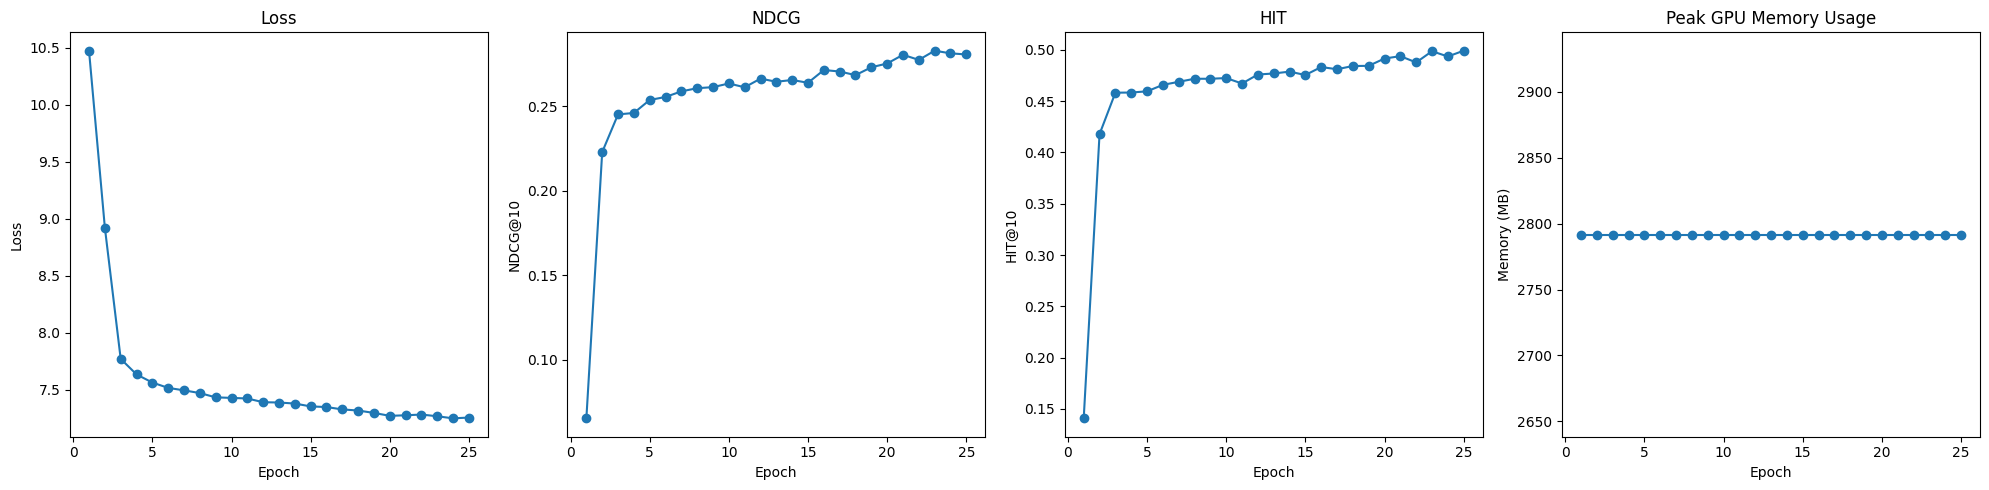

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
epochs_range = list(range(1, len(loss_list) + 1))

ax[0].plot(epochs_range, loss_list, marker='o')
ax[0].set_title('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs_range, ndcg_list, marker='o')
ax[1].set_title('NDCG')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('NDCG@10')

ax[2].plot(epochs_range, hit_list, marker='o')
ax[2].set_title('HIT')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('HIT@10')

ax[3].plot(epochs_range, memory_list, marker='o')
ax[3].set_title('Peak GPU Memory Usage')
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Memory (MB)')

plt.tight_layout()
plt.show()